## Load libraries

In [27]:
from skimage import io
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

import os,sys
from importlib import reload
import h5py

## Parameters

In [28]:
prepared_dataset = './data/mnist-noisy.h5'
model_directory  =  'denoiser&classifier'

latent_dim       = 10

train_prop       = .8
batch_size       = 128
epochs           = 30
fit_verbosity    = 1

## Retrieve dataset

In [29]:
def reload_prepared_dataset(train_prop=0.8, shuffle=True, seed=False, filename='./data/mnist-noisy.h5'):

    # Load saved dataset
    with  h5py.File(filename,'r') as f:
        clean_data  = f['clean_data'][:]
        noisy_data  = f['noisy_data'][:]
        class_data  = f['class_data'][:]
    print('Loaded.')

    # ---- Shuffle
    #
    if shuffle:
        p = np.random.permutation(len(clean_data))
        clean_data, noisy_data, class_data = clean_data[p], noisy_data[p], class_data[p]
        print('Shuffled.')

    # ---- Split
    #
    n=int(len(clean_data)*train_prop)
    clean_train, clean_test = clean_data[:n], clean_data[n:]
    noisy_train, noisy_test = noisy_data[:n], noisy_data[n:]
    class_train, class_test = class_data[:n], class_data[n:]
    print(f'splited ({train_prop}).') 


    print('clean_train shape is : ', clean_train.shape)
    print('clean_test  shape is : ', clean_test.shape)
    print('noisy_train shape is : ', noisy_train.shape)
    print('noisy_test  shape is : ', noisy_test.shape)
    print('class_train shape is : ', class_train.shape)
    print('class_test  shape is : ', class_test.shape)
    return  clean_train,clean_test, noisy_train,noisy_test, class_train,class_test

In [30]:
clean_train,clean_test, noisy_train,noisy_test, class_train, class_test= reload_prepared_dataset(shuffle = True, filename=prepared_dataset )

Loaded.
Shuffled.
splited (0.8).
clean_train shape is :  (56000, 28, 28, 1)
clean_test  shape is :  (14000, 28, 28, 1)
noisy_train shape is :  (56000, 28, 28, 1)
noisy_test  shape is :  (14000, 28, 28, 1)
class_train shape is :  (56000,)
class_test  shape is :  (14000,)


## Model 

In [31]:
# Encoder
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x         = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)
z         = layers.Dense(latent_dim)(x)

encoder = keras.Model(inputs, z, name="encoder")
#encoder.summary()

In [32]:
# Decoder
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x       = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
# decoder.summary()

In [33]:
# AE

inputs    = keras.Input(shape=(28, 28, 1))

latents   = encoder(inputs)
outputs   = decoder(latents)

ae = keras.Model(inputs,outputs, name='ae')

In [34]:
# CNN 

hidden1     = 100
hidden2     = 100

inputs    = keras.Input(shape=(28, 28, 1))

x         = keras.layers.Conv2D(8, (3,3),  activation='relu')(inputs)
x         = keras.layers.MaxPooling2D((2,2))(x)
x         = keras.layers.Dropout(0.2)(x)

x         = keras.layers.Conv2D(16, (3,3), activation='relu')(x)
x         = keras.layers.MaxPooling2D((2,2))(x)
x         = keras.layers.Dropout(0.2)(x)

x         = keras.layers.Flatten()(x)
x         = keras.layers.Dense(100, activation='relu')(x)
x         = keras.layers.Dropout(0.5)(x)

outputs   = keras.layers.Dense(10, activation='softmax')(x)

cnn       = keras.Model(inputs, outputs, name='cnn')

In [35]:
# final model

inputs    = keras.Input(shape=(28, 28, 1))

denoised = ae(inputs)
classcat = cnn(inputs)

model = keras.Model(inputs, [denoised, classcat])

model.compile(optimizer='rmsprop', 
              loss={'ae':'binary_crossentropy', 'cnn':'sparse_categorical_crossentropy'},
              loss_weights=[1,1],
              metrics={'cnn':'accuracy'} )

In [36]:
# callbacks


filename = model_directory + '/best_model.h5'
callback_bestmodel = tf.keras.callbacks.ModelCheckpoint(filepath=filename, verbose=0, save_best_only=True)

In [37]:
history = model.fit(noisy_train, [clean_train, class_train],
                 batch_size      = batch_size,
                 epochs          = epochs,
                 verbose         = fit_verbosity,
                 validation_data = (noisy_test, [clean_test, class_test]),
                 callbacks       = callback_bestmodel  )

Epoch 1/30
438/438 [==============================] - 5s 9ms/step - loss: 1.7205 - ae_loss: 0.2588 - cnn_loss: 1.4616 - cnn_accuracy: 0.4989 - val_loss: 1.0536 - val_ae_loss: 0.2240 - val_cnn_loss: 0.8295 - val_cnn_accuracy: 0.7511
Epoch 2/30
438/438 [==============================] - 4s 8ms/step - loss: 1.1281 - ae_loss: 0.1989 - cnn_loss: 0.9292 - cnn_accuracy: 0.6910 - val_loss: 0.8276 - val_ae_loss: 0.1859 - val_cnn_loss: 0.6416 - val_cnn_accuracy: 0.8063
Epoch 3/30
438/438 [==============================] - 3s 7ms/step - loss: 0.9472 - ae_loss: 0.1789 - cnn_loss: 0.7682 - cnn_accuracy: 0.7465 - val_loss: 0.6965 - val_ae_loss: 0.1717 - val_cnn_loss: 0.5248 - val_cnn_accuracy: 0.8326
Epoch 4/30
438/438 [==============================] - 3s 7ms/step - loss: 0.8587 - ae_loss: 0.1688 - cnn_loss: 0.6899 - cnn_accuracy: 0.7750 - val_loss: 0.6311 - val_ae_loss: 0.1635 - val_cnn_loss: 0.4676 - val_cnn_accuracy: 0.8525
Epoch 5/30
438/438 [==============================] - 3s 7ms/step - loss

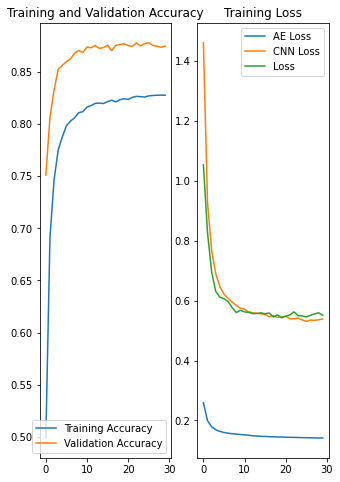

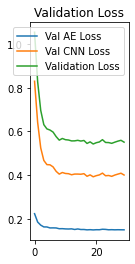

In [38]:
acc     = history.history['cnn_accuracy']
val_acc = history.history['val_cnn_accuracy']

ae_loss  = history.history['ae_loss']
cnn_loss = history.history['cnn_loss']
loss     = history.history['loss']

val_ae_loss  = history.history['val_ae_loss']
val_cnn_loss = history.history['val_cnn_loss']
val_loss     = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, ae_loss, label='AE Loss')
plt.plot(epochs_range, cnn_loss, label='CNN Loss')
plt.plot(epochs_range, val_loss, label='Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

plt.subplot(1, 3, 3)
plt.plot(epochs_range, val_ae_loss, label='Val AE Loss')
plt.plot(epochs_range, val_cnn_loss, label='Val CNN Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Validation Loss')
plt.show()

In [39]:
model = keras.models.load_model(f'{model_directory}/best_model.h5')

In [40]:
denoised_test, classcat_test = model.predict(noisy_test)

print('Denoised images   (denoised_test) shape : ',denoised_test.shape)
print('Predicted classes (classcat_test) shape : ',classcat_test.shape)

438/438 [==============================] - 1s 2ms/step
Denoised images   (denoised_test) shape :  (14000, 28, 28, 1)
Predicted classes (classcat_test) shape :  (14000, 10)


In [41]:
def plot(images):
    for i in range(7):
        plt.subplot(170 + 1 + i)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    # show the figure
    plt.show()

Noisy test images (input):


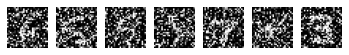

Denoised images (output):


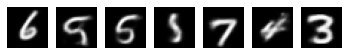

Real test images :


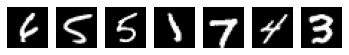

In [42]:
i=random.randint(0,len(denoised_test)-7)
j=i+7

print('Noisy test images (input):')
plot(noisy_test[i:j])

print('Denoised images (output):')
plot(denoised_test[i:j])

print('Real test images :')
plot(clean_test[i:j])

Accuracy :
Classification accuracy : 0.8771
Few examples :


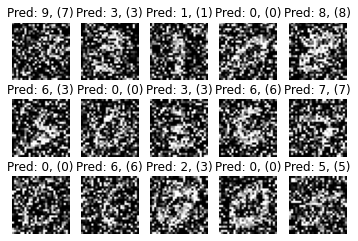

In [62]:
score = model.evaluate(noisy_test, [clean_test, class_test], verbose=0)

print("Accuracy :")
print(f'Classification accuracy : {score[3]:4.4f}')

print("Few examples :")
classid_test  = np.argmax(classcat_test, axis=-1)

for i in range(15):
    plt.subplot(3,5 ,1 + i)
    plt.imshow(noisy_test[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Pred: {classid_test[i]}, ({class_test[i]})')
# show the figure
plt.show()

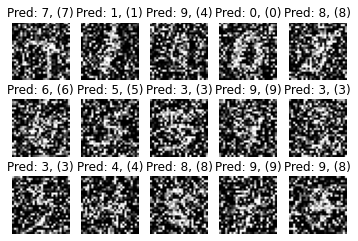

In [63]:
for i in range(15):
    plt.subplot(3,5 ,1 + i)
    plt.imshow(noisy_test[i+15], cmap='gray')
    plt.axis('off')
    plt.title(f'Pred: {classid_test[i+15]}, ({class_test[i+15]})')
# show the figure
plt.show()

## An another model for denoise and classify MNIST Dataset

In [66]:
# Encoder

inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x         = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)
z         = layers.Dense(latent_dim)(x)

encoder = keras.Model(inputs, z, name="encoder")
# encoder.summary()

# Decoder
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x       = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
# decoder.summary()


# AE
inputs    = keras.Input(shape=(28, 28, 1))

latents   = encoder(inputs)
outputs   = decoder(latents)

ae = keras.Model(inputs,outputs, name='ae')

In [70]:
# CNN1
inputs    = keras.Input(shape=(28, 28, 1))

x         = keras.layers.Conv2D(8, (3,3),  activation='relu')(inputs)
x         = keras.layers.MaxPooling2D((2,2))(x)
x         = keras.layers.Dropout(0.2)(x)

x         = keras.layers.Conv2D(16, (3,3), activation='relu')(x)
x         = keras.layers.MaxPooling2D((2,2))(x)
x         = keras.layers.Dropout(0.2)(x)

x         = keras.layers.Flatten()(x)
x         = keras.layers.Dense(100, activation='relu')(x)
outputs   = keras.layers.Dropout(0.5)(x)

cnn1       = keras.Model(inputs, outputs, name='cnn1')


In [69]:
# CNN2
inputs    = keras.Input(shape=(28, 28, 1))

x         = keras.layers.Conv2D(32, (5,5),  activation='relu')(inputs)
x         = keras.layers.MaxPooling2D((2,2))(x)
x         = keras.layers.Dropout(0.3)(x)

x         = keras.layers.Conv2D(64, (5,5), activation='relu')(x)
x         = keras.layers.MaxPooling2D((2,2))(x)
x         = keras.layers.Dropout(0.3)(x)

x         = keras.layers.Flatten()(x)
x         = keras.layers.Dense(50, activation='relu')(x)
outputs   = keras.layers.Dropout(0.3)(x)

cnn2       = keras.Model(inputs, outputs, name='cnn2')

In [71]:
inputs    = keras.Input(shape=(28, 28, 1))

denoised = ae(inputs)

branch_1 = cnn1(inputs)
branch_2 = cnn2(inputs)

x        = keras.layers.concatenate([branch_1,branch_2], axis=1)

classcat = keras.layers.Dense(10, activation='softmax', name='cnn')(x)


model = keras.Model(inputs, [denoised, classcat])

model.compile(optimizer='rmsprop', 
              loss={'ae':'binary_crossentropy', 'cnn':'sparse_categorical_crossentropy'},
              loss_weights=[1,1],
              metrics={'cnn':'accuracy'} )

In [72]:
history = model.fit(noisy_train, [clean_train, class_train],
                 batch_size      = batch_size,
                 epochs          = epochs,
                 verbose         = fit_verbosity,
                 validation_data = (noisy_test, [clean_test, class_test]),
                 callbacks       = callback_bestmodel  )

Epoch 1/30
438/438 [==============================] - 5s 9ms/step - loss: 1.3088 - ae_loss: 0.2599 - cnn_loss: 1.0489 - cnn_accuracy: 0.6420 - val_loss: 0.7585 - val_ae_loss: 0.2144 - val_cnn_loss: 0.5441 - val_cnn_accuracy: 0.8240
Epoch 2/30
438/438 [==============================] - 3s 8ms/step - loss: 0.7805 - ae_loss: 0.1954 - cnn_loss: 0.5851 - cnn_accuracy: 0.8092 - val_loss: 0.6100 - val_ae_loss: 0.1834 - val_cnn_loss: 0.4266 - val_cnn_accuracy: 0.8641
Epoch 3/30
438/438 [==============================] - 4s 10ms/step - loss: 0.6796 - ae_loss: 0.1762 - cnn_loss: 0.5034 - cnn_accuracy: 0.8347 - val_loss: 0.5403 - val_ae_loss: 0.1723 - val_cnn_loss: 0.3680 - val_cnn_accuracy: 0.8849
Epoch 4/30
438/438 [==============================] - 4s 8ms/step - loss: 0.6311 - ae_loss: 0.1680 - cnn_loss: 0.4631 - cnn_accuracy: 0.8498 - val_loss: 0.5170 - val_ae_loss: 0.1672 - val_cnn_loss: 0.3498 - val_cnn_accuracy: 0.8886
Epoch 5/30
438/438 [==============================] - 4s 8ms/step - los

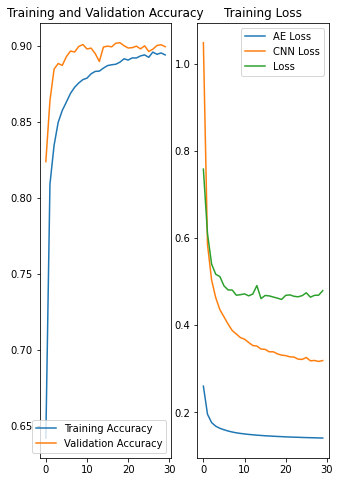

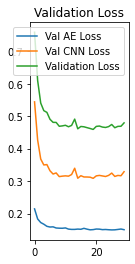

In [73]:
acc     = history.history['cnn_accuracy']
val_acc = history.history['val_cnn_accuracy']

ae_loss  = history.history['ae_loss']
cnn_loss = history.history['cnn_loss']
loss     = history.history['loss']

val_ae_loss  = history.history['val_ae_loss']
val_cnn_loss = history.history['val_cnn_loss']
val_loss     = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, ae_loss, label='AE Loss')
plt.plot(epochs_range, cnn_loss, label='CNN Loss')
plt.plot(epochs_range, val_loss, label='Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

plt.subplot(1, 3, 3)
plt.plot(epochs_range, val_ae_loss, label='Val AE Loss')
plt.plot(epochs_range, val_cnn_loss, label='Val CNN Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Validation Loss')
plt.show()

In [76]:
model2 = keras.models.load_model(f'{model_directory}/best_model.h5')

In [77]:
denoised_test, classcat_test = model2.predict(noisy_test)

print('Denoised images   (denoised_test) shape : ',denoised_test.shape)
print('Predicted classes (classcat_test) shape : ',classcat_test.shape)

438/438 [==============================] - 1s 2ms/step
Denoised images   (denoised_test) shape :  (14000, 28, 28, 1)
Predicted classes (classcat_test) shape :  (14000, 10)


Noisy test images (input):


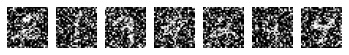

Denoised images (output):


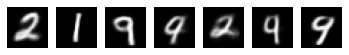

Real test images :


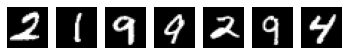

In [78]:
i=random.randint(0,len(denoised_test)-7)
j=i+7

print('Noisy test images (input):')
plot(noisy_test[i:j])

print('Denoised images (output):')
plot(denoised_test[i:j])

print('Real test images :')
plot(clean_test[i:j])

Accuracy :
Classification accuracy : 0.9003
Few examples :


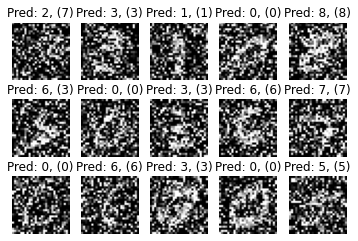

In [79]:
score = model.evaluate(noisy_test, [clean_test, class_test], verbose=0)

print("Accuracy :")
print(f'Classification accuracy : {score[3]:4.4f}')

print("Few examples :")
classid_test  = np.argmax(classcat_test, axis=-1)

for i in range(15):
    plt.subplot(3,5 ,1 + i)
    plt.imshow(noisy_test[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Pred: {classid_test[i]}, ({class_test[i]})')
# show the figure
plt.show()

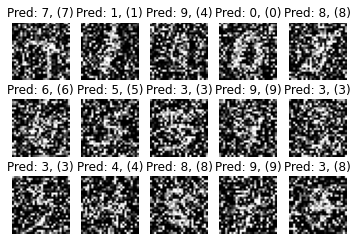

In [80]:
for i in range(15):
    plt.subplot(3,5 ,1 + i)
    plt.imshow(noisy_test[i+15], cmap='gray')
    plt.axis('off')
    plt.title(f'Pred: {classid_test[i+15]}, ({class_test[i+15]})')
# show the figure
plt.show()